# Accesibilidad a áreas verdes en la Zona Metropolitana del Valle de México

En este taller vamos a calcular diferentes modelos de accesibilidad a áreas verdes. La idea es ir trabajando de lo más simple a los más complejo. Empezaremos con un modelo de conectividad basado sólo en distancias entre centroides e iremos complicando las cosas a partir de ahí, primero usando conectividad de red...

## Preparación de datos

Como siempre, lo primero que tenemos que hacer es preparar los datos. En este caso vamos a usar el marco cartográfico del Censo de 2020 a nivel AGEB y una cartografía de áreas verdes que preparé para un proyecto integrando datos de INEGI y de OSM.

La cartografía de áreas verdes viene en un geopackage para todo el país y la cartografía censal viene en shapes para la CDMX y el Estado de México. Para cortar todo con la silueta de la ZMVM tenemos un shaper con el límite metropolitano.

Los datos para obtener la demanda (población, en principio) vienen en csvs que tenemos que unir con la geometría de las manzanas. Eso lo haremos después de tener los recortes para economizar un poco.

In [1]:
import pandas as pd
import geopandas as gpd

### Leer datos

In [2]:
cdmx = gpd.read_file("datos/agebs_cdmx_2020.zip")
edomex = gpd.read_file("datos/agebs_edomex_2020.zip")
areas_verdes = gpd.read_file("datos/parques.gpkg", layer='parques')
limite_metropolitano = gpd.read_file("datos/limite_metropolitano.zip")

Hacemos un merge de las agebs para tenerlas en un solo dataframe

In [3]:
agebs_todas = pd.concat([cdmx, edomex])
agebs_todas

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry
0,0901000011716,09,010,0001,1716,"POLYGON ((2787237.541 816989.461, 2787288.728 ..."
1,0901000012150,09,010,0001,2150,"POLYGON ((2794154.458 823013.444, 2794155.774 ..."
2,0901000011133,09,010,0001,1133,"POLYGON ((2795690.723 820050.788, 2795684.238 ..."
3,0901000011307,09,010,0001,1307,"POLYGON ((2792584.475 815678.668, 2792624.325 ..."
4,0901000010281,09,010,0001,0281,"POLYGON ((2788845.392 823526.074, 2788840.549 ..."
...,...,...,...,...,...,...
4315,151250001004A,15,125,0001,004A,"POLYGON ((2808390.934 857912.251, 2808614.795 ..."
4316,1512500010016,15,125,0001,0016,"POLYGON ((2808318.468 857265.867, 2808312.961 ..."
4317,1512500010020,15,125,0001,0020,"POLYGON ((2807637.181 858200.578, 2807639.598 ..."
4318,1512500070054,15,125,0007,0054,"POLYGON ((2806574.677 856458.207, 2806484.183 ..."


### Proyectar
Para poder cortar las geometrías y trabajarlas todas juntas necesitamos que estén en la misma proyección

In [4]:
print(cdmx.crs)
print(edomex.crs)
print(areas_verdes.crs)
print(limite_metropolitano.crs)

PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["ITRF2008",DATUM["International_Terrestrial_Reference_Frame_2008",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1061"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","8999"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridian",-102],PARAMETER["standard_parallel_1",17.5],PARAMETER["standard_parallel_2",29.5],PARAMETER["false_easting",2500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["ITRF2008",DATUM["International_Terrestrial_Reference_Frame_2008",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1061"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","8999"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",12],PARAMETER["central_meridia

Las primeras dos están en la proyección nueva de INEGI, las áreas verdes en la anterior y el límite metropolitano está en 32614. Tenemos que poner todas en la misma proyección, podría ser cualquiera de las planas (vamos a medir longitudes). Usemos la nueva del INEGI

In [5]:
areas_verdes = areas_verdes.to_crs(cdmx.crs)
limite_metropolitano = limite_metropolitano.to_crs(cdmx.crs)

### Cortar con el límite metropolitano

In [6]:
from geopandas.tools import sjoin
areas_verdes = sjoin(areas_verdes, limite_metropolitano)
agebs_zmvm = sjoin(agebs_todas, limite_metropolitano)

### Áreas y centroides

Como vamos a trabajar la accesibilidad en primera instancia sólo entre los centroides de las agebs y las de las áreas verdes, entonces vamos a necesitar dataframes con el área de los parques (que vamos a usar como la oferta en el modelo de accesibilidad) y con los centroides de las agebs y su población total (que va a ser la demanda).

**Nota:** vamos a hacer una copia de las capas para usdar los centroides, en caso de que queramos después usar las geometrías originales

In [7]:
areas_verdes['area'] = areas_verdes.geometry.area
areas_verdes_centroides = areas_verdes.copy()
areas_verdes_centroides['geometry'] = areas_verdes_centroides.centroid
# Nos quedamos sólo con los campos que queremos
areas_verdes_centroides = areas_verdes_centroides.loc[:, ['geometry', 'area']]
agebs_zmvm_centroides = agebs_zmvm.copy()
agebs_zmvm_centroides['geometry'] = agebs_zmvm_centroides.centroid
# Nos quedamos sólo con los campos que queremos
agebs_zmvm_centroides = agebs_zmvm_centroides.loc[:, ['CVEGEO', 'geometry']]

### Datos de población
Para modelar la demanda necesitamos ahora unir a las agebs los datos de población, esos vienen en csvs por estado. Lo primero es leerlos y juntarlos en un solo dataframe

In [8]:
datos_cdmx = pd.read_csv("datos/conjunto_de_datos_ageb_urbana_09_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
datos_edomex = pd.read_csv("datos/conjunto_de_datos_ageb_urbana_15_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
datos_zmvm = pd.concat([datos_cdmx, datos_edomex])
# seleccionamos las filas que contienen los totales para cada AGEB
datos_zmvm = datos_zmvm.loc[datos_zmvm['NOM_LOC'] == 'Total AGEB urbana', :]
# Construimos una columna con la clave de ageb
datos_zmvm['CVEGEO'] = datos_zmvm['ENTIDAD'] + datos_zmvm['MUN'] + datos_zmvm['LOC'] + datos_zmvm['AGEB']
# Nos quedamos sólo con las columnas que vamos a usar (sólo queremos los datos de población)
datos_zmvm = datos_zmvm.loc[:, ['CVEGEO', 'POBTOT']]

Ahora los podemos unir con los centroides de las agebs

In [9]:
agebs_zmvm_centroides = agebs_zmvm_centroides.merge(datos_zmvm, on="CVEGEO", how="inner")
agebs_zmvm_centroides

,CVEGEO,geometry,POBTOT
0,0901000011716,POINT (2787091.708 816590.463),7042
1,0901000012150,POINT (2793986.972 823047.548),4588
2,0901000011133,POINT (2794967.016 819439.549),2203
3,0901000011307,POINT (2792230.506 815397.361),2914
4,0901000010281,POINT (2788669.707 823554.634),237
...,...,...,...
5753,151250001004A,POINT (2808504.425 857540.602),1020
5754,1512500010016,POINT (2807986.700 857448.943),2686
5755,1512500010020,POINT (2807958.932 857067.980),3209
5756,1512500070054,POINT (2806373.386 856257.252),1573


## Modelo basado en distancia euclidiana

La primera aproximación que vamos a usar es crear un modelo de accesibilidad basado en la distancia euclidiana entre los centroides de las agebs y los de los parques. Para esto, el primer paso es construir una matriz de costos

### Matriz de costos

Para construir la matriz de costos necesitamos obtener el producto cruz de nuestros datos de origen y destino.

In [10]:
# Nos conviene tener una columna que identifique a cada parque
areas_verdes_centroides = areas_verdes_centroides.reset_index().rename({'index':'id_parque'}, axis=1)
# Creamos el producto cruz
cost_df = agebs_zmvm_centroides[['CVEGEO']].merge(areas_verdes_centroides[['id_parque']], how='cross')
# Agregamos una columna de costo con puros ceros
cost_df['cost'] = 0
cost_df

,CVEGEO,id_parque,cost
0,0901000011716,7596,0
1,0901000011716,7597,0
2,0901000011716,7598,0
3,0901000011716,7599,0
4,0901000011716,7600,0
...,...,...,...
61518467,1512500070069,71554,0
61518468,1512500070069,71555,0
61518469,1512500070069,71556,0
61518470,1512500070069,71557,0


In [11]:
# renombramos las columnas para que tengan más sentido
cost_df.columns = ['origen', 'destino', 'cost']
cost_df

,origen,destino,cost
0,0901000011716,7596,0
1,0901000011716,7597,0
2,0901000011716,7598,0
3,0901000011716,7599,0
4,0901000011716,7600,0
...,...,...,...
61518467,1512500070069,71554,0
61518468,1512500070069,71555,0
61518469,1512500070069,71556,0
61518470,1512500070069,71557,0


### Instancia de accesibilidad

Ya tenemos los datos preparados, ahora podemos crear una instancia de la clase `access` con nuestros centros de demanda y de oferta. 

In [12]:
from access import Access, weights
A = Access(demand_df            = agebs_zmvm_centroides,
           demand_index         = 'CVEGEO',
           demand_value         = 'POBTOT',
           supply_df            = areas_verdes_centroides,
           supply_index         = 'id_parque',
           supply_value         = 'area',
           cost_df              = cost_df,
           cost_origin          = 'origen',
           cost_dest            = 'destino',
           cost_name            = 'cost',
           neighbor_cost_df     = cost_df,
           neighbor_cost_origin = 'origen',
           neighbor_cost_dest   = 'destino',
           neighbor_cost_name   = 'cost')

### Distancia euclidiana
Ahora podemos calcular la distancia euclidiana y guardar el resultado en la columna `cost` que inicializamos arriba

In [13]:
A.create_euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)
A.cost_df

,origen,destino,cost,euclidean,origin,dest
0,0901000011716,7596,0,49538.320373,0901000011716,7596
1,0901000011716,7597,0,52735.680942,0901000011716,7597
2,0901000011716,7598,0,51258.712440,0901000011716,7598
3,0901000011716,7599,0,51347.156450,0901000011716,7599
4,0901000011716,7600,0,51323.205923,0901000011716,7600
...,...,...,...,...,...,...
61518467,1512500070069,71554,0,29869.107149,1512500070069,71554
61518468,1512500070069,71555,0,29463.688048,1512500070069,71555
61518469,1512500070069,71556,0,29383.351658,1512500070069,71556
61518470,1512500070069,71557,0,29851.667475,1512500070069,71557


### Modelos de accesibilidad
Ahora podemos calcular todos los modelos que vienen en el ejemplo original de PySal pero usando la distancia euclidiana 

In [15]:
# stepwise weight dictionaries
fn30 = weights.step_fn({1000 : 1, 2000 : 0.68, 3000 : 0.22})
fn60 = weights.step_fn({2000 : 1, 4000 : 0.68, 6000 : 0.22})
# gaussian media de 1000 metros 
gaussian = weights.gaussian(1000)
# gravity catchement pesado por gravedad
gravity = weights.gravity(scale = 60, alpha = -1)

In [16]:
# A.weighted_catchment    (name = "gravity",  weight_fn = gravity, supply_cost = "euclidean")
# A.fca_ratio             (name = "fca",      max_cost = 500, supply_cost = "euclidean")
# A.fca_ratio             (name = "fca700",   max_cost = 700, supply_cost = "euclidean") 
# A.fca_ratio             (name = "fca1000",  max_cost = 1000, supply_cost = "euclidean")
# A.fca_ratio             (name = "fca1500",  max_cost = 1500, supply_cost = "euclidean")
# A.two_stage_fca         (name = "2sfca",    max_cost = 1000, supply_cost = "euclidean")
# A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = fn30, cost = "euclidean")
# A.enhanced_two_stage_fca(name = "2sfca60",  weight_fn = fn60, cost = "euclidean")
# A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian, cost = "euclidean")
# A.three_stage_fca       (name = "3sfca")

A.raam(name = "raam", tau = 1000, cost = "euclidean"); 
A.raam(name = "raam20000", tau = 2000, cost = "euclidean");

In [24]:
mapa_accesibilidad = agebs_zmvm_centroides.set_index('CVEGEO')[["geometry"]].join(A.norm_access_df, how = "inner")
def plot(v, ax = None, leg = True):    
    swap_colors = "raam" in v
    mapa_accesibilidad.plot(v, legend = leg, figsize = (5, 5), 
                cmap = "viridis_r" if swap_colors else "viridis", 
                markersize = 5, alpha = 0.8, ax = ax,
                vmin = mapa_accesibilidad[v].quantile(0.05), vmax = mapa_accesibilidad[v].quantile(0.95)).set_axis_off()

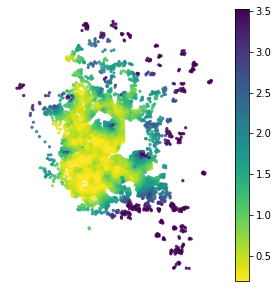

In [25]:
plot("raam_area")

In [26]:
import matplotlib.pyplot as plt
import contextily as ctx

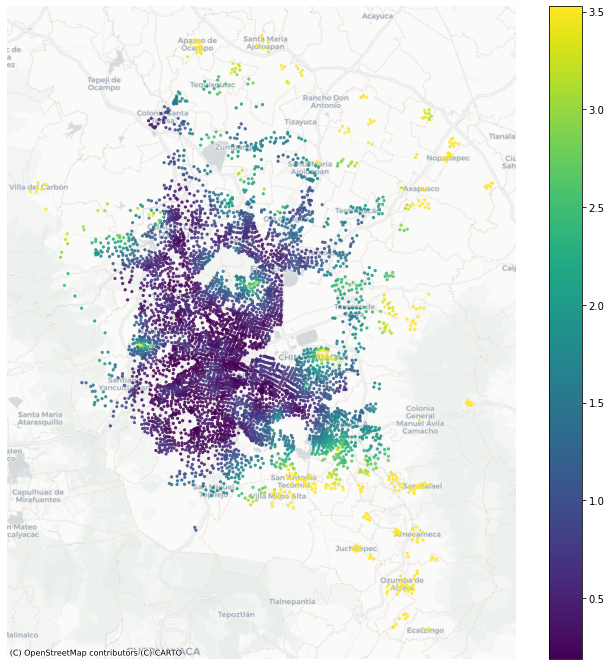

In [35]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = mapa_accesibilidad.to_crs(epsg=3857).plot('raam_area', legend = True, 
                cmap =  "viridis", 
                markersize = 5, alpha = 0.8, ax = ax,
                vmin = mapa_accesibilidad['raam_area'].quantile(0.05), vmax = mapa_accesibilidad['raam_area'].quantile(0.95))
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)